<img src="quora.png">

<h1 style='text-align:center; font-size:40px;'> Quora Question Pairs </h1>

# 1. Business Problem

## 1.1 Description

Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.

Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.

Credits: Kaggle

#### Problem Statement
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

## 1.2 Sources/Useful Links
- Source: https://www.kaggle.com/c/quora-question-pairs 

__ Useful Links __
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

## 1.3 Real World Business Objectives & Constraints

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

# 2. Machine Learning Problem

## 2.1 Data Overview

- Data will be in a file train.csv 
- Train.csv contains 5 columns : qid1, qid2, question1, question2, is_duplicate 
- Size of train.csv - 60MB 
- Number of rows in Train.csv = 404,290

## 2.2 Example Data Point 

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

## 2.3 Problem Type

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

## 2.4 Train & Test Construction

We build train and test by randomly splittin in the ratio of 70:30 or 80:20, whatever we choose as we have sufficient point to work with.

# 3. Exploratory Data Analysis [EDA]

In [1]:
# Library Imports:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc
import re

from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

## 3.1 Reading Data & Basic Statistics

In [2]:
df = pd.read_csv('../train/train.csv')
print("Number of data points:", df.shape[0])

Number of data points: 404290


In [3]:
# Preview of the data:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [4]:
# Metadata data:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


_We are given a minimal number of data fields here, consisting of_ :
- id: Looks like a simple rowID
- qid{1, 2}: The unique ID of each question in the pair
- question{1, 2}: The actual textual contents of the questions.
- is_duplicate: The label that we are trying to predict - whether the two questions are duplicates of each other.

## 3.2 Distributtion of Data Points

### 3.2.1 Among Output Classes

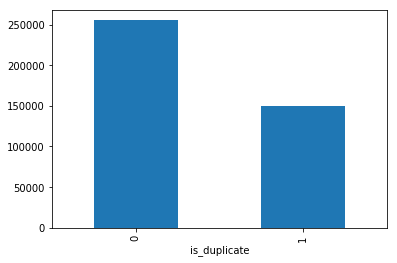

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total # of quetion pairs for training:\n   {}'.format(df.shape[0]))

~> Total # of quetion pairs for training:
   404290


In [7]:
print('~> Question pairs which are not similar (is_duplicate = 0): \
{}%\n'.format(100 - round(df.is_duplicate.mean()*100, 2)))
print('~> Question pairs which are similar (is_duplicate = 1): \
{}%\n'.format(round(df.is_duplicate.mean()*100, 2)))

~> Question pairs which are not similar (is_duplicate = 0): 63.08%

~> Question pairs which are similar (is_duplicate = 1): 36.92%



### 3.2.2 Number of Unique Points

In [8]:
# pandas.Series() takes in a list, and returns an array object
qids = pd.Series(df.qid1.tolist() + df.qid2.tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print('Total number of unique qeustions are: {}\n'.format(unique_qs))

print('Number of uniqe questions that appear more than one time: {} ({}%)\n'.\
     format(qs_morethan_onetime, round(qs_morethan_onetime/unique_qs*100, 2)))

print('Max number of times a single question is repeated: {}\n'.\
     format(max(qids.value_counts())))

# q_vals = qids.value_counts()
# print(q_vals.values)

Total number of unique qeustions are: 537933

Number of uniqe questions that appear more than one time: 111780 (20.78%)

Max number of times a single question is repeated: 157



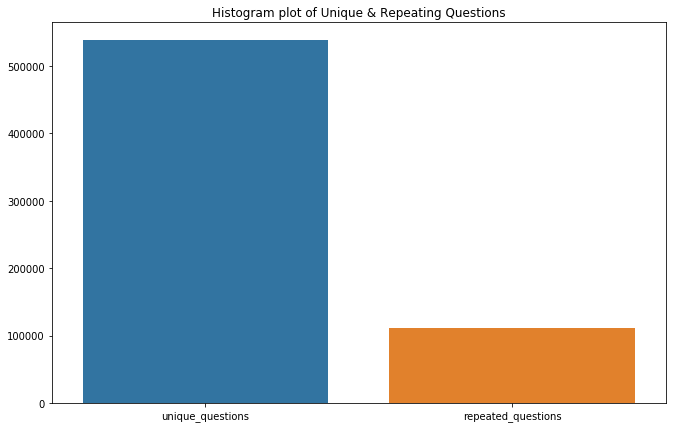

In [9]:
x = ["unique_questions", "repeated_questions"]
y = [unique_qs, qs_morethan_onetime]

plt.figure(figsize=(11,7))
plt.title("Histogram plot of Unique & Repeating Questions")
sns.barplot(x,y)
plt.show()

#### Checking for Duplicates

In [10]:
# Checking whether there any repeated pair of numbers or not:
pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2'])\
.count().reset_index()

print("Number of duplicate questions", pair_duplicates.shape[0] - df.shape[0])

Number of duplicate questions 0


### 3.2.4 Number of occurrences of each question

Maximum number of times a single question is repeated: 157



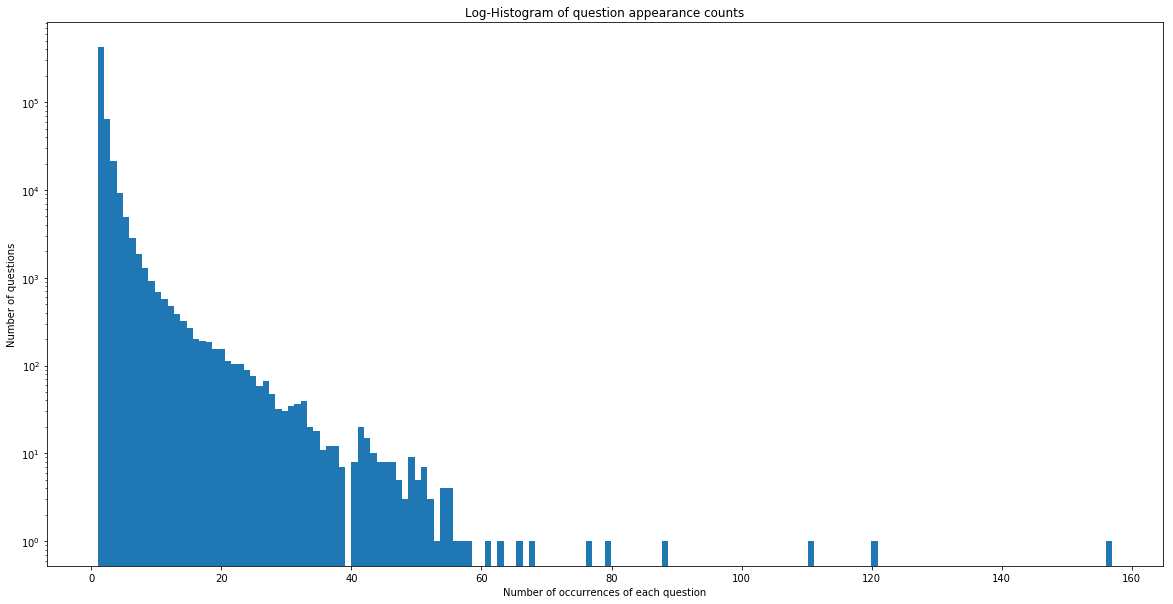

In [11]:
plt.figure(figsize=(20,10))
plt.hist(qids.value_counts(), bins=160)
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts')
plt.xlabel('Number of occurrences of each question')
plt.ylabel('Number of questions')
print("Maximum number of times a single question is repeated: {}\n"\
      .format(max(qids.value_counts())))

Note: The y-axis in the plot above has a logarithmic notation.

Most of the questions occur only once. But there are some questions that occur more than 60 times. The maximum number of times a question appears is 157 times according to the plot above.

### 3.2.5 Checking for NULL values

In [12]:
# Checking whether there are any rows with null values:
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

            id    qid1    qid2                         question1 question2  \
105780  105780  174363  174364    How can I develop android app?       NaN   
201841  201841  303951  174364  How can I create an Android app?       NaN   

        is_duplicate  
105780             0  
201841             0  


In [13]:
# Filling the null values with '':
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print(nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


There are 2 rows with null values in 'question2' column of our dataset.

## 3.3 Basic Feature Extraction [before cleaning]

Constructing some basic custom features out of the dataset as:
- __freq_qid1__ = Frequency of qid1's
- __freq_qid2__ = Frequency of qid2's
- __q1len__ = Length of q1
- __q2len__ = Length of q2
- __q1_n_words__ = Number of words in Question 1
- __q2_n_words__ = Number of words in Question 2
- __word_Common__ = (Number of common unique words in Question 1 and Question 2)
- __word_Total__ =(Total num of words in Question 1 + Total num of words in Question 2)
- __word_share__ = (word_common)/(word_Total)
- __freq_q1+q2__ = sum total of frequency of qid1 and qid2
- __freq_q1+q2__ = absolute difference of frequency of qid1 and qid2

In [14]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

# print the first 5 rows of the modified data frame:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


### 3.3.1 Analysis of some of the extracted features
- Checking whether there are questions which have only a single word.

In [15]:
print("Minimum length of the questions in 'question1' attribute:",\
     min(df.q1_n_words))
print("Minimum length of the questions in 'question2' attribute:",\
     min(df.q2_n_words))

print("Number of Questions in 'question1' attribute with minimum length:",\
     df[df.q1_n_words == min(df.q1_n_words)].shape[0])
print("Number of Questions in 'question2' attribute with minimum length:",\
     df[df.q2_n_words == min(df.q2_n_words)].shape[0])

Minimum length of the questions in 'question1' attribute: 1
Minimum length of the questions in 'question2' attribute: 1
Number of Questions in 'question1' attribute with minimum length: 67
Number of Questions in 'question2' attribute with minimum length: 22


#### 3.3.1.1 Feature: word_share

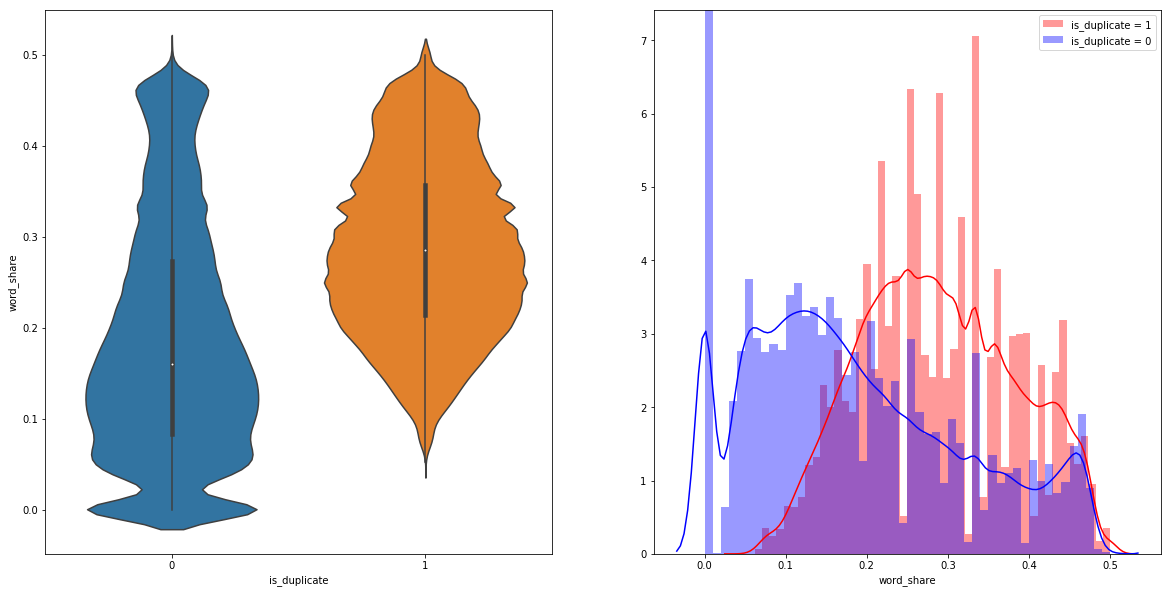

In [17]:
plt.figure(figsize=(20,10))

# Violin Plot:
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='word_share', data=df[0:])

# Histogram/PDF:
plt.subplot(1,2,2)
sns.distplot(df[df.is_duplicate == 1.0]['word_share'][0:], \
            label='is_duplicate = 1', color='red')
sns.distplot(df[df.is_duplicate == 0.0]['word_share'][0:], \
            label='is_duplicate = 0', color='blue')

plt.legend()
plt.show()

- The distributions for normalized word_share have some overlap on the dar right-hand side, _i.e.,_ there are quite a lot of questions in both _question1_ and _question2_ with high amount of word similarity.
- Average word_share and common no. of words of _question1_ and _question2_ is more when they are similar to each other.

#### 3.3.1.2 Feature: word_Common

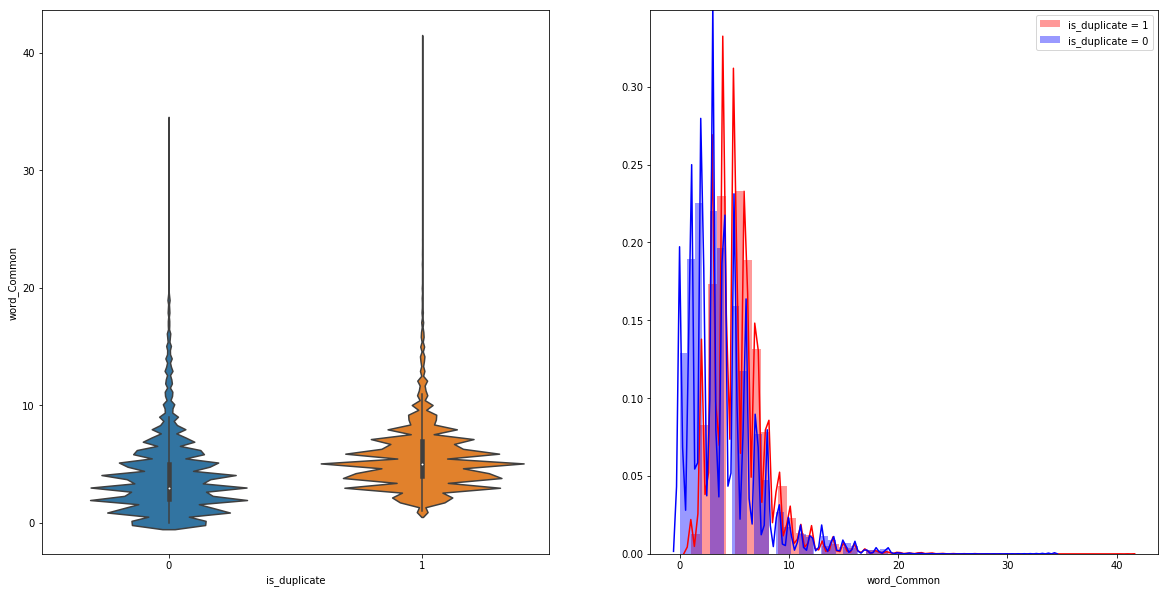

In [18]:
plt.figure(figsize=(20,10))

# Violin Plot:
plt.subplot(1,2,1)
sns.violinplot(x='is_duplicate', y='word_Common', data=df[0:])

# PDF / Histogram Plot:
plt.subplot(1,2,2)
sns.distplot(df[df.is_duplicate == 1.0]['word_Common'][0:], \
            label='is_duplicate = 1', color='red')
sns.distplot(df[df.is_duplicate == 0.0]['word_Common'][0:], \
            label='is_duplicate = 0', color='blue')

plt.legend()
plt.show()

The distributions of the word_Common feature and non-similar questions are highly overlapping.

## 3.4 Preprocessing of Text
Steps Involved:
- Removing HTML Tags
- Removing Punctuations
- Performing Stemming
- Removing Stopwords
- Expanding the Contracted words like "won't" to "would not"

In [19]:
# Library imports:
import warnings
warnings.filterwarnings('ignore')

# Importing fuzzywuzzy module because we need to get some form
# of similarity between the sentences of q1 and q2, using just the words
# in each sentence
from fuzzywuzzy import fuzz

# Importing the foll. library show a word-cloud plot:
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS

# General imports:
from os import path
from PIL import Image

In [20]:
# https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    uncleaned_data = pd.read_csv('df_fe_without_preprocessing_train.csv',\
                                 encoding='latin-1')
    uncleaned_data = uncleaned_data.fillna('')
else:
    print('df_fe_without_preprocessing_train.csv file not found!')

In [22]:
uncleaned_data.head()

,id,qid1,qid2,question1,question2,is_duplicate,freq_qid1,freq_qid2,q1len,q2len,q1_n_words,q2_n_words,word_Common,word_Total,word_share,freq_q1+q2,freq_q1-q2
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,1,1,66,57,14,12,10.0,23.0,0.434783,2,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,4,1,51,88,8,13,4.0,20.0,0.200000,5,3
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,1,1,73,59,14,10,4.0,24.0,0.166667,2,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,1,1,50,65,11,9,0.0,19.0,0.000000,2,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,3,1,76,39,13,7,2.0,20.0,0.100000,4,2


In [28]:
# Text Preprocessing Code:
def preprocess_text(x):
    """
    
    """
    
    # Convert the string to lower case ccharacters:
    x = str(x).lower()
    
    # Replace all the expansions with contracted characters/words:
    x = x.replace(",000,000","m").replace(",000","k").replace("′","'")\
        .replace("’","'").replace("won't","will not")\
        .replace("cannot","can not").replace("can't","can not")\
        .replace("n't"," not").replace("what's","what is").replace("'re"," are")\
        .replace("it's","it is").replace("'ve"," have").replace("i'm","i am")\
        .replace("he's","he is").replace("she's","she is").replace("'s","own")\
        .replace("%","percent").replace("₹"," rupee").replace("$"," dollar")\
        .replace("€","euro").replace("'ll"," will")
    
    # Replace any sequence of numbers followed by 000000 as m, i.e., million:
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    
    # Replace any sequence of numbers followed by 000 as k, i.e., thousand:
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    # Create instance of Porter Stemmer:
    porter = PorterStemmer()
    
    # Create instance of all the non-alphanumeric sequences:
    pattern = re.compile('\W')
    
    # Removing all the non-alphanumeric characters/sequences from x:
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    # Find Stem form using Porter Stemmer:
    if type(x) == type(''):
        x = porter.stem(x)
        ex = BeautifulSoup(x)
        x = ex.get_text()
        
    return x

The usage of the function defined above will be seen when while extracting some advanced features from our text.

## 3.5 Advanced Feature Extraction [NLP & Fuzzy Features]

Definition:
- __Token__: You get a token by splitting sentence delimited by a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Normal Features:
1. __cwc_min__ :  Ratio of common_word_count to min length of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
2. __cwc_max__ :  Ratio of common_word_count to max length of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
3. __csc_min__ :  Ratio of common_stop_count to min length of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
4. __csc_max__ :  Ratio of common_stop_count to max length of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
5. __ctc_min__ :  Ratio of common_token_count to min length of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

6. __ctc_max__ :  Ratio of common_token_count to max length of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
7. __last_word_eq__ :  Check if Last word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

8. __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
9. __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

10. __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2

<br><br><br>
Fuzzy Features:
- __fuzz_ratio__ :  The value of fuzz_ratio depends on the edit distance between 2 words, _i.e._, Number of characters to add in string1 to get string2, or number of characters to remove in string1 to get string2. <br> Usage: https://github.com/seatgeek/fuzzywuzzy#usage <br>
Explaination: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


- __fuzz_partial_ratio__ :  The value of fuzz_partial_ratio depends on the edit distance between 2 strings, but not the perfect edit distance, _i.e._,  as long as words/characters are there in string1 that match with string2 partially, the ratio will be high. <br> Usage: https://github.com/seatgeek/fuzzywuzzy#usage <br>
Explaination: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/ 


- __token_sort_ratio__ : We sort the string1 and string2 token by token, before taking the fuzz_ratio. <br>
Usage: https://github.com/seatgeek/fuzzywuzzy#usage <br>
Explaination: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- __token_set_ratio__ : We sort the string1 and string2 token by token, and then find: 
 - t0 = the common tokens to both string1 and string2.
 - t1 = the common tokens to both string1 and string2 + rest of the sorted tokens in string1. 
 - t3 = the common tokens to both string1 and string2 + rest of the sorted tokens in string2. <br><br> Now, <pre>token_set_ratio = max(fuzz_ratio(t0,t1), fuzz_ratio(t0,t2), fuzz_ratio(t1,t2))</pre> <br>
Usage: https://github.com/seatgeek/fuzzywuzzy#usage <br>
Explaination: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/


- __longest_substr_ratio__ :  Ratio of length longest common substring to min length of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))


In [30]:
# Main code for advanced feature extraction:
# Contains all the function definitions to extract all the advanced features.

# To get the results within 4 decimal points:
SAFE_DIV = 0.0001

# Get a list of stop words in english:
STOP_WORDS = stopwords.words('english')

def get_token_features(q1,q2):
    """
    Function to get the first 10 Normal Features.
    """
    
    # Since we have 10 Normal Features:
    token_features = [0.0]*10
    
    # Converting the sentence into tokens:
    q1_tokens = q1.split()
    q2_tokens = q2.split()
    
    # If either q1 or q2 is empty, return token_features
    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    
    # Get the non-stopwords in q1 and q2:
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    # Get the stopwords in q1 and q2:
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from q1 & q2:
    common_word_count = len(q1_words.intersection(q2_words))
    # common_word_count = len(q1_words & q2_words)
    
    # Get the common stopwords from q1 & q2:
    common_stop_count = len(q1_stops.intersection(q2_stops))
    # common_stop_count = len(q1_stops & q2_stops)
    
    # Get the common tokens from q1 & q2:
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    # common_token_count = len(set(q1_tokens) & set(q2_tokens))
    
    # cwc_min:
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    # cwc_max:
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    
    
    # csc_min:
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    # csc_max:
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    
    
    # ctc_min:
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    # ctc_max:
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    
    # last_word_eq:
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # first_word_eq:
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    # abs_len_diff:
    token_features[8] = abs(len(q1_tokens) - len(q1_tokens))
    
    # mean_len:
    token_features[9] = (len(q1_tokens) + len(q2_tokens)) / 2
    
    # return the token_features list which has all the Normal Features:
    return token_features


def get_longest_substr_ratio(a, b):
    """
    Function to get longest common substring ratio, i.e., lcs_substr_ratio.
    """
    lcs = list(distance.lcsubstrings(a, b))
    if len(lcs) == 0:
        return 0
    else:
        return len(lcs[0]) / (min(len(a), len(b)) + 1)


def extract_features(df):
    """
    Function that will be used to extract all the advanced features 
    along with text preprocessing.
    """
    
    # Preprocessing each q1 and q2 in the dataset:
    df.question1 = df.question1.fillna("").apply(preprocess_text)
    df.question2 = df.question2.fillna("").apply(preprocess_text)
    
    print("Token Features....")
    
    # Get the list of all Normal Features:
    token_features = df.apply(lambda x: get_token_features(x.question1, x.question2), axis=1)
    
    
    # Merging all the Normal Features with the actual dataset:
    
    # common_word_count ratios:
    df['cwc_min']       = list(map(lambda x: x[0], token_features))
    df['cwc_max']       = list(map(lambda x: x[1], token_features))
    
    # common_stopword_count ratios:
    df['csc_min']       = list(map(lambda x: x[2], token_features))
    df['csc_max']       = list(map(lambda x: x[3], token_features))
    
    # common_token_count ratios:
    df['ctc_min']       = list(map(lambda x: x[4], token_features))
    df['ctc_max']       = list(map(lambda x: x[5], token_features))
    
    # Whether first/last word of q1 and q2 are equal or not:
    df['last_word_eq']  = list(map(lambda x: x[6], token_features))
    df['first_word_eq'] = list(map(lambda x: x[7], token_features))
    
    # Absolute difference between the lengths of q1 and q2:
    df['abs_len_diff']  = list(map(lambda x: x[8], token_features))
    
    # Mean length of tokens in q1+q2:
    df['mean_len']      = list(map(lambda x: x[9], token_features))
    
    
    
    # Computing Fuzzy Features and mergin them into the dataset:
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    
    print("Fuzzy Features....")
    
    df['token_set_ratio']      = df.apply(lambda x: fuzz.token_set_ratio(x.question1, x.question2), axis=1)
    df['token_sort_ratio']     = df.apply(lambda x: fuzz.token_sort_ratio(x.question1, x.question2), axis=1)
    df['fuzz_ratio']           = df.apply(lambda x: fuzz.QRatio(x.question1, x.question2), axis=1)
    df['fuzz_parital_ratio']   = df.apply(lambda x: fuzz.partial_ratio(x.question1, x.question2), axis=1)
    df['longest_substr_ratio'] = df.apply(lambda x: get_longest_substr_ratio(x.question1, x.question2), axis=1)
    
    return df

In [34]:
import time

start = time.time()

if os.path.isfile('nlp_features_train.csv'):
    data = pd.read_csv("nlp_features_train.csv", encoding='latin-1')
    data.fillna('')
else:
    print("Extracting features for train:")
    data = pd.read_csv("../train/train.csv")
    data = extract_features(data)
    data.to_csv("nlp_features_train.csv", index=False)
    
print("Total time taken to run this snippet of code was {} seconds"\
      .format(round(time.time()-start, 2)))

data.head(2)

Extracting features for train:
Token Features....
Fuzzy Features....
Total time taken to run this snippet of code was 2846.22 seconds


,id,qid1,qid2,question1,question2,is_duplicate,cwc_min,cwc_max,csc_min,csc_max,...,ctc_max,last_word_eq,first_word_eq,abs_len_diff,mean_len,token_set_ratio,token_sort_ratio,fuzz_ratio,fuzz_parital_ratio,longest_substr_ratio
0,0,1,2,what is the step by step guide to invest in sh...,what is the step by step guide to invest in sh...,0,0.999980,0.833319,0.999983,0.999983,...,0.785709,0.0,1.0,0.0,13.0,100,93,93,100,0.982759
1,1,3,4,what is the story of kohinoor koh i noor dia...,what would happen if the indian government sto...,0,0.799984,0.399996,0.749981,0.599988,...,0.466664,0.0,1.0,0.0,12.5,86,63,66,75,0.596154
